In [1]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

#1.Introduction

## Features
In order to make preditions, we use the following features: 

1. Previous changes in the yield curve at the following tenors: 30 Year Bond (b30ret), 20 Year Bond(b20ret), 10 Year Bond (b10ret), 7 Year Bond (b7ret),
5 Year Bond (b5ret), 2 Year Bond (b2ret), 1 Year Bond (b1ret), 90 Day Bill (t90ret), 30 Day Bill (t30ret).

In [3]:
df= read_csv('data_project.csv')
df= df.set_index('caldt')
df.drop('cpiret',axis=1,inplace=True)

In [4]:
df.head()

,b30ret,b20ret,b10ret,b7ret,b5ret,b2ret,b1ret,t90ret,t30ret
caldt,,,,,,,,,
01/31/2001,-0.001917,0.002511,0.004164,0.011923,0.013510,0.013519,0.012048,0.006900,0.005243
02/28/2001,0.014203,0.018639,0.011636,0.012849,0.011310,0.006873,0.004732,0.003967,0.003653
03/30/2001,-0.014758,-0.007316,0.002750,0.006763,0.008259,0.007193,0.007367,0.004678,0.004320
04/30/2001,-0.043105,-0.031123,-0.027449,-0.015447,-0.008237,0.002154,0.004721,0.004470,0.003864
05/31/2001,0.008805,0.003703,0.001373,0.003136,0.002011,0.005381,0.006094,0.003853,0.003183


# 2.Exploratory Data Analysis

## 2.1 Descriptive Statistics

In [5]:
df.describe()

,b30ret,b20ret,b10ret,b7ret,b5ret,b2ret,b1ret,t90ret,t30ret
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,0.006501,0.006073,0.004340,0.004359,0.003638,0.002259,0.001656,0.001257,0.001116
std,0.041140,0.031507,0.019900,0.016554,0.012032,0.004680,0.002458,0.001427,0.001304
min,-0.147382,-0.105931,-0.066819,-0.046952,-0.033809,-0.012968,-0.003310,-0.000129,-0.000037
25%,-0.019769,-0.014729,-0.006636,-0.004922,-0.003167,-0.000446,0.000142,0.000107,0.000054
50%,0.006949,0.005143,0.002828,0.003156,0.003162,0.001525,0.000828,0.000817,0.000711
75%,0.027633,0.024286,0.015188,0.013529,0.010035,0.004304,0.002629,0.001906,0.001691
max,0.174083,0.144461,0.085378,0.081895,0.045233,0.020658,0.013061,0.006900,0.005243


## 2.2 Data Visualization

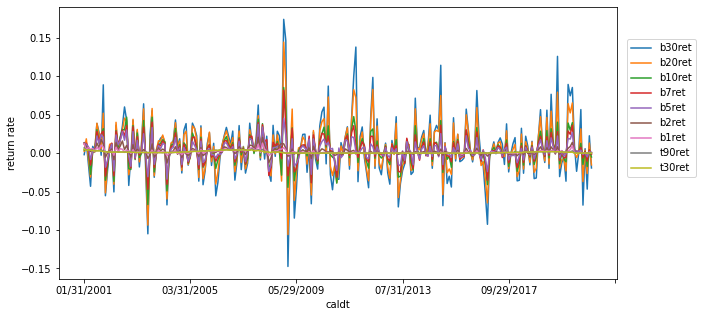

In [6]:
import matplotlib.pyplot as plt
df.plot(figsize=(10,5))
plt.ylabel("return rate")
plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2)
plt.show()

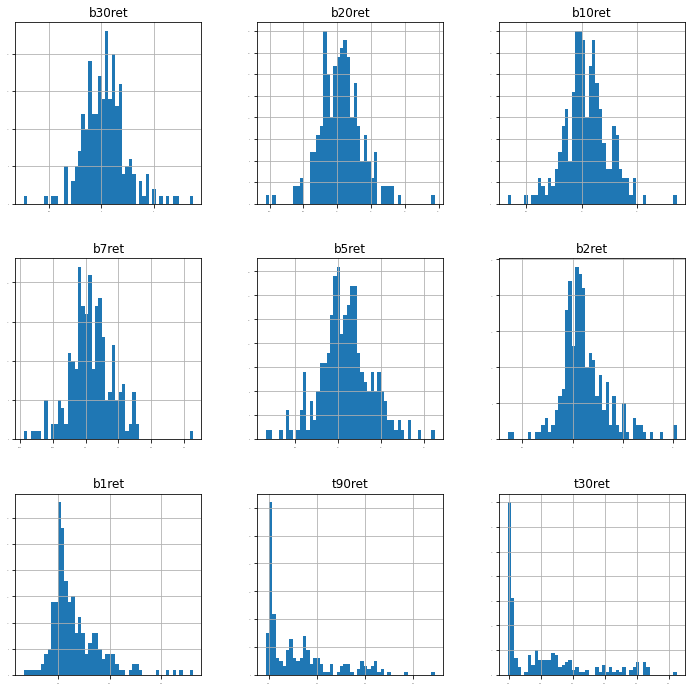

In [7]:
df.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

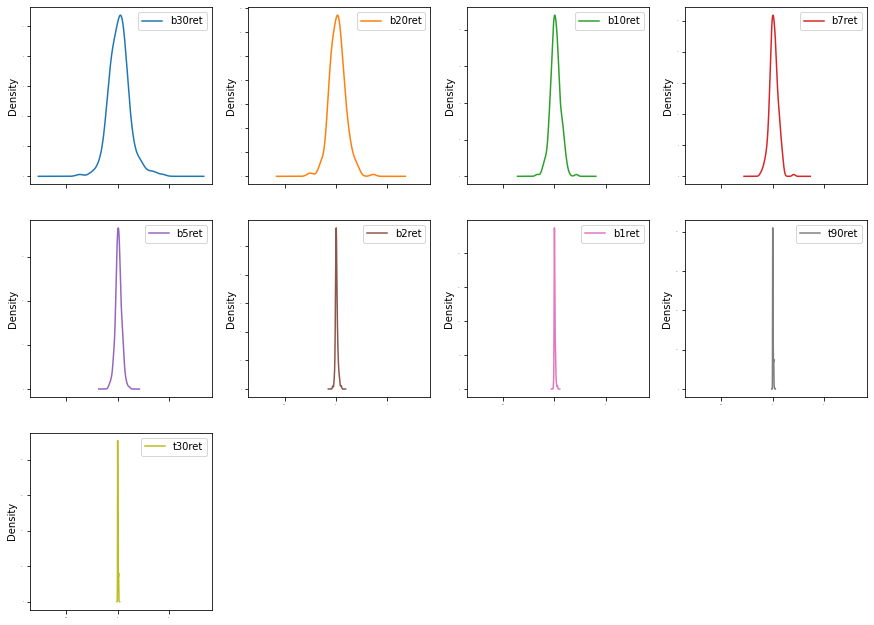

In [8]:
df.plot(kind='density', subplots=True, layout=(4,4), sharex=True, legend=True, fontsize=1, figsize=(15,15))
plt.show()

In [9]:
df.corr()

,b30ret,b20ret,b10ret,b7ret,b5ret,b2ret,b1ret,t90ret,t30ret
b30ret,1.000000,0.980193,0.912239,0.849399,0.770476,0.538483,0.357756,0.048456,0.013841
b20ret,0.980193,1.000000,0.956083,0.905115,0.827610,0.582925,0.384100,0.053674,0.018406
b10ret,0.912239,0.956083,1.000000,0.973848,0.928433,0.703491,0.481210,0.094180,0.048589
b7ret,0.849399,0.905115,0.973848,1.000000,0.975565,0.791418,0.566298,0.141479,0.084434
b5ret,0.770476,0.827610,0.928433,0.975565,1.000000,0.873430,0.640033,0.184740,0.120507
b2ret,0.538483,0.582925,0.703491,0.791418,0.873430,1.000000,0.879845,0.441166,0.352943
b1ret,0.357756,0.384100,0.481210,0.566298,0.640033,0.879845,1.000000,0.727540,0.632457
t90ret,0.048456,0.053674,0.094180,0.141479,0.184740,0.441166,0.727540,1.000000,0.977626
t30ret,0.013841,0.018406,0.048589,0.084434,0.120507,0.352943,0.632457,0.977626,1.000000


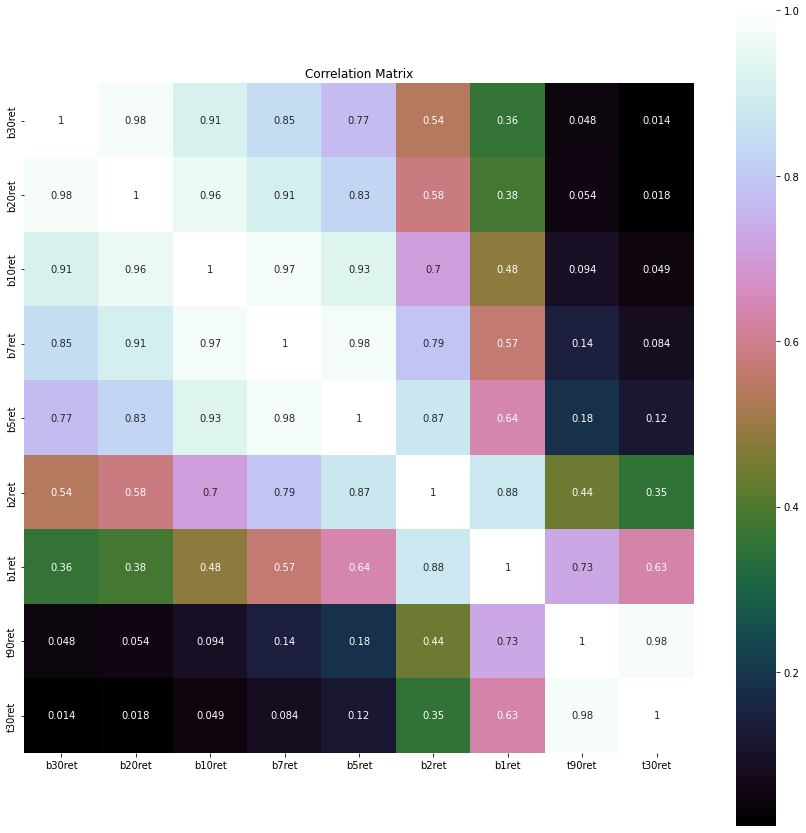

In [10]:
correlation = df.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')
plt.show()

<Figure size 1080x1080 with 0 Axes>

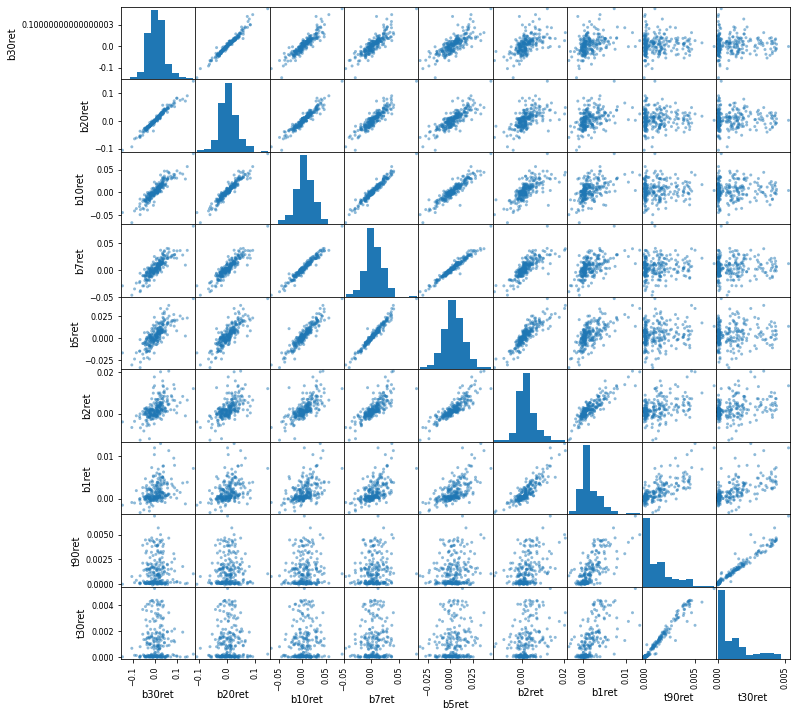

In [11]:
plt.figure(figsize=(15,15))
scatter_matrix(df,figsize=(12,12))
plt.show()

# 3.Data Preparation and analysis

We found that there is no null values in our dataset and the data are normalized which means we don't need to standardize the data.

##3.1 Data Cleaning

In [12]:
print('Null Values =',df.isnull().values.any())
# no nan value which is good

Null Values = False


We are using PCA to reduce the dimentionality of our original dataset.

##3.2 Dimensionality Reduction

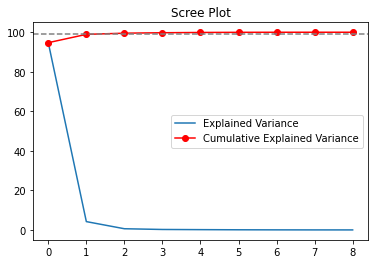

In [13]:
Cov = np.cov(df.T)

def get_sorted_eigen(df_cov):
  C = np.cov(df_cov.T)
  eigenValues, eigenVectors = np.linalg.eigh(C)
  args = (-eigenValues).argsort()
  eigenValues = eigenValues[args]
  eigenVectors = eigenVectors[:, args]
  return eigenValues,eigenVectors

eigenValues=get_sorted_eigen(df)[0]
eigenVectors=get_sorted_eigen(df)[1]

eigValSum = sum(eigenValues)
expVar = [eigV/eigValSum*100 for eigV in eigenValues]
cumExpVar = np.cumsum(expVar)
cumExpVar
plt.plot(expVar[:10], label='Explained Variance')
plt.plot(cumExpVar[:10], 'r-o', label='Cumulative Explained Variance')
plt.axhline(y=99,linestyle="--",color="gray")
plt.title("Scree Plot")
plt.legend()
plt.show()

We will attempt to compress the feature set down to dimension 2 according to the scree plot.

## 3.3 Target Selection
In the supervised regression framework used for this case study, three tensors(i.e b1, t90 and t30) of the yield curve are the predicted variable. These tenors are most relative to the changes in the yield curve.

In [14]:
return_period = 1
Y = df.loc[:, ['b1ret', 't90ret', 't30ret']].shift(-return_period)
Y.columns = [col+'_pred' for col in Y.columns]

X = df.loc[:, ['b30ret', 'b20ret', 'b10ret', 'b7ret', 'b5ret', 'b2ret', 'b1ret', 't90ret', 't30ret']]

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.columns]
X = dataset.loc[:, X.columns]

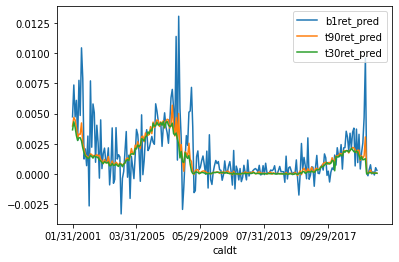

In [15]:
Y.plot()

In [16]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
for col in Y.columns:
    temp_Y = dataset[col]
    temp_X = dataset.loc[:, X.columns]
    fit = bestfeatures.fit(temp_X,temp_Y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    print(col)
    print(featureScores.nlargest(9,'Score'))  #print 9 best features
    print('--------------')

b1ret_pred
    Specs       Score
8  t30ret  148.538924
7  t90ret  147.099090
6   b1ret   55.838268
5   b2ret   21.883467
4   b5ret    2.986488
3   b7ret    1.321192
2  b10ret    0.349663
0  b30ret    0.297861
1  b20ret    0.194720
--------------
t90ret_pred
    Specs        Score
8  t30ret  3122.723514
7  t90ret  1301.853923
6   b1ret   111.957710
5   b2ret    26.783673
4   b5ret     2.848916
3   b7ret     1.362456
2  b10ret     0.490651
1  b20ret     0.090364
0  b30ret     0.055070
--------------
t30ret_pred
    Specs        Score
8  t30ret  5253.969492
7  t90ret  1511.488664
6   b1ret   102.189822
5   b2ret    21.148501
4   b5ret     1.711675
3   b7ret     0.750026
2  b10ret     0.275537
1  b20ret     0.015822
0  b30ret     0.000527
--------------


#4.Evaluate Algorithms and Models

##4.1 AutoEncoders 

In [17]:
encoding_dim= 2 # got from pca

rates=np.array(dataset)
x_train = rates
x_test = rates
np.random.seed(42)

In [18]:
print(dataset.shape)

(239, 12)


In [19]:
input_img = Input(shape=(12,))
# activation = 'relu' #relu
final_activation = 'sigmoid' #sigmoid

encoded = Dense(8, activation='tanh')(input_img)
encoded = Dense(4, activation='relu')(encoded)

encoded = Dense(encoding_dim, activation='tanh')(encoded)  #Middle layer

decoded = Dense(4, activation='tanh')(encoded)
decoded = Dense(8, activation='relu')(decoded)
decoded = Dense(12, activation=final_activation)(decoded)

In [20]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='Adam', loss='mean_squared_error')

history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test),
                verbose=1).history

Epoch 1/50
8/8 [==============================] - 1s 27ms/step - loss: 0.2456 - val_loss: 0.2427
Epoch 2/50
8/8 [==============================] - 0s 6ms/step - loss: 0.2405 - val_loss: 0.2371
Epoch 3/50
8/8 [==============================] - 0s 6ms/step - loss: 0.2344 - val_loss: 0.2303
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.2271 - val_loss: 0.2222
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 0.2185 - val_loss: 0.2127
Epoch 6/50
8/8 [==============================] - 0s 6ms/step - loss: 0.2083 - val_loss: 0.2016
Epoch 7/50
8/8 [==============================] - 0s 8ms/step - loss: 0.1967 - val_loss: 0.1892
Epoch 8/50
8/8 [==============================] - 0s 7ms/step - loss: 0.1837 - val_loss: 0.1755
Epoch 9/50
8/8 [==============================] - 0s 6ms/step - loss: 0.1696 - val_loss: 0.1610
Epoch 10/50
8/8 [==============================] - 0s 8ms/step - loss: 0.1549 - val_loss: 0.1460
Epoch 11/50
8/8 [=====================

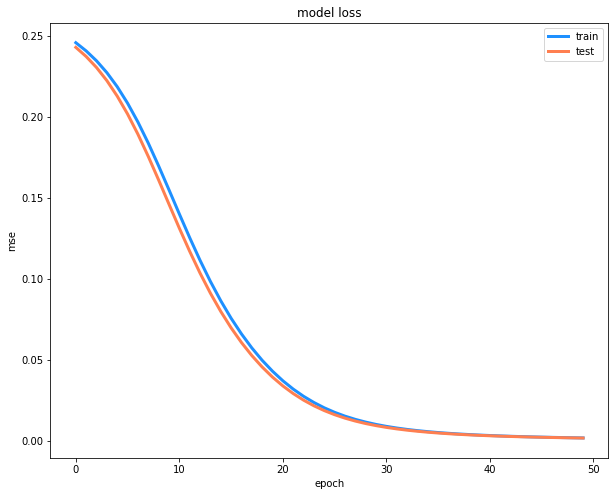

In [21]:
plt.figure(figsize=(10, 8))
plt.plot(history['loss'], c='dodgerblue', lw=3)
plt.plot(history['val_loss'], c='coral', lw=3)
plt.title('model loss')
plt.ylabel('mse'); plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

##4.2 Train/Test Split and Evaluation metrics

In [22]:
# split out validation dataset for the end

validation_size = 0.3

#In case the data is not dependent on the time series, then train and test split randomly
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=0)

we use the prebuild scikit models to run a K fold analysis on our training data. We then train the model on the full training data and use it for prediction of the test data. The parameters for the K fold analysis are defined as -

In [23]:
# test options for regression
seed = 0
num_folds = 10
scoring = 'neg_mean_squared_error'

##4.3 Compare Models and Algorithms

In [24]:
# spot check the algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
#Neural Network
models.append(('MLP', MLPRegressor()))

In [25]:
kfold_results = []
names = []
validation_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle = True, random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    names.append(name)

    # Finally we Train on the full period and test against validation
    res = model.fit(X_train, Y_train)
    validation_result = np.mean(np.square(res.predict(X_validation) - Y_validation))
    validation_results.append(validation_result)
    train_result = np.mean(np.square(res.predict(X_train) - Y_train))
    train_results.append(train_result)
    
    msg = "%s: \nAverage CV error: %s \nStd CV Error: (%s) \nTraining Error:\n%s \nTest Error:\n%s" % \
    (name, str(cv_results.mean()), str(cv_results.std()), str(train_result), str(validation_result))
    print(msg)
    print('----------')

LR: 
Average CV error: 1.3350345440547322e-06 
Std CV Error: (6.950716357453581e-07) 
Training Error:
b1ret_pred     2.970465e-06
t90ret_pred    1.163483e-07
t30ret_pred    4.528781e-08
dtype: float64 
Test Error:
b1ret_pred     4.186715e-06
t90ret_pred    9.554956e-08
t30ret_pred    3.657631e-08
dtype: float64
----------
LASSO: 
Average CV error: 2.954051196188219e-06 
Std CV Error: (1.0459167203240074e-06) 
Training Error:
b1ret_pred     0.000005
t90ret_pred    0.000002
t30ret_pred    0.000002
dtype: float64 
Test Error:
b1ret_pred     0.000007
t90ret_pred    0.000002
t30ret_pred    0.000002
dtype: float64
----------
EN: 
Average CV error: 2.954051196188219e-06 
Std CV Error: (1.0459167203240074e-06) 
Training Error:
b1ret_pred     0.000005
t90ret_pred    0.000002
t30ret_pred    0.000002
dtype: float64 
Test Error:
b1ret_pred     0.000007
t90ret_pred    0.000002
t30ret_pred    0.000002
dtype: float64
----------
KNN: 
Average CV error: 2.5997422240637254e-06 
Std CV Error: (7.72079594

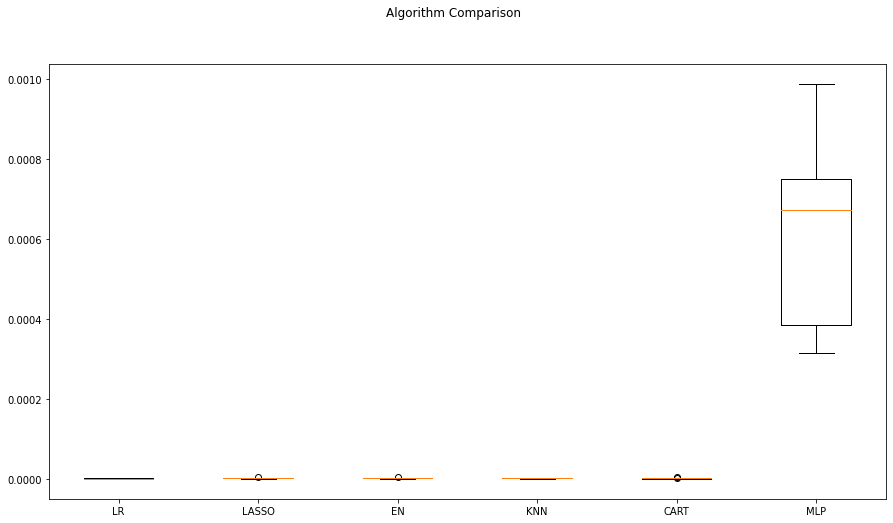

In [26]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

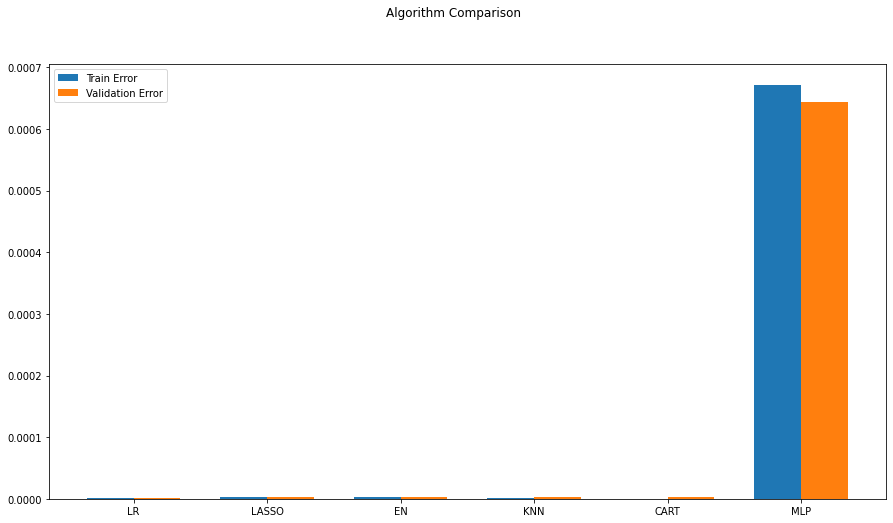

In [27]:
# compare algorithms
fig = plt.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, [x.mean() for x in train_results],  width=width, label='Train Error')
plt.bar(ind + width/2, [x.mean() for x in validation_results], width=width, label='Validation Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show()

Based on the plots above, we will select Linear Regression, KNN and LASSO models to perform the further prediction.

#5.Model Tuning and Grid Search

In [28]:
#Grid search : Knn 

k_range = list(range(1, 31))
param_grid = {'n_neighbors': k_range, 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, shuffle = True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000002 using {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
-0.000004 (0.000002) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
-0.000004 (0.000002) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
-0.000003 (0.000001) with: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'uniform'}
-0.000003 (0.000001) with: {'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
-0.000003 (0.000001) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
-0.000003 (0.000001) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
-0.000003 (0.000001) with: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'uniform'}
-0.000002 (0.000001) with: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}
-0.000003 (0.000001) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
-0.000003 (0.000001) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'

In [29]:
#Grid search : Lasso 

cv1 = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)
lasso_alphas = np.linspace(0, 0.2, 21)
param_grid1 = {'alpha': lasso_alphas, 'selection': ['cyclic', 'random']}
model1 = Lasso()
grid1 = GridSearchCV(estimator=model1, param_grid=param_grid1, scoring=scoring, cv=cv1, n_jobs=-1)
grid1_result = grid1.fit(X_train, Y_train)
print("Best: %f using %s" % (grid1_result.best_score_, grid1_result.best_params_))
means = grid1_result.cv_results_['mean_test_score']
stds = grid1_result.cv_results_['std_test_score']
params = grid1_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000001 using {'alpha': 0.0, 'selection': 'random'}
-0.000001 (0.000001) with: {'alpha': 0.0, 'selection': 'cyclic'}
-0.000001 (0.000001) with: {'alpha': 0.0, 'selection': 'random'}
-0.000003 (0.000001) with: {'alpha': 0.01, 'selection': 'cyclic'}
-0.000003 (0.000001) with: {'alpha': 0.01, 'selection': 'random'}
-0.000003 (0.000001) with: {'alpha': 0.02, 'selection': 'cyclic'}
-0.000003 (0.000001) with: {'alpha': 0.02, 'selection': 'random'}
-0.000003 (0.000001) with: {'alpha': 0.03, 'selection': 'cyclic'}
-0.000003 (0.000001) with: {'alpha': 0.03, 'selection': 'random'}
-0.000003 (0.000001) with: {'alpha': 0.04, 'selection': 'cyclic'}
-0.000003 (0.000001) with: {'alpha': 0.04, 'selection': 'random'}
-0.000003 (0.000001) with: {'alpha': 0.05, 'selection': 'cyclic'}
-0.000003 (0.000001) with: {'alpha': 0.05, 'selection': 'random'}
-0.000003 (0.000001) with: {'alpha': 0.06, 'selection': 'cyclic'}
-0.000003 (0.000001) with: {'alpha': 0.06, 'selection': 'random'}
-0.000003 (0.00000

#6.Finalise the Model

In [30]:
train_size = int(len(X) * (1-validation_size))
prediction_AE = autoencoder.predict(dataset)

##6.1 Results and comparison of KNN, AutoEncoders, Linear Regression and LASSO

In [31]:
#Results and comparison of Knn, Autoencoder and OLS

#Finalize Knn model
model = KNeighborsRegressor(metric = 'manhattan', n_neighbors = 9, weights = 'distance')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)
mse_Knn = mean_squared_error(Y_validation, predictions)
r2_Knn = r2_score(Y_validation, predictions)

# autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='Adam', loss='mean_squared_error')
predictions_2 = prediction_AE[train_size:len(X),:3]

mse_AE = mean_squared_error(Y_validation, predictions_2)
r2_AE = r2_score(Y_validation, predictions_2)

# Linear Regression
model_3 = LinearRegression()
model_3.fit(X_train, Y_train)
predictions_3 = model_3.predict(X_validation)
mse_OLS = mean_squared_error(Y_validation, predictions_3)
r2_OLS = r2_score(Y_validation, predictions_3)

#Finalize Lasso model
model_4 = Lasso(alpha=0, selection = 'random')
model_4.fit(X_train, Y_train)
predictions_4 = model_4.predict(X_validation)
mse_Lasso = mean_squared_error(Y_validation, predictions_4)
r2_Lasso = r2_score(Y_validation, predictions_4)

print("MSE Knn = %f, MSE AE = %f, MSE OLS = %f, MSE Lasso = %f" % (mse_Knn, mse_AE, mse_OLS, mse_Lasso))
print("R2 Knn = %f, R2 AE = %f, R2 OLS = %f, R2 Lasso = %f" % (r2_Knn, r2_AE, r2_OLS, r2_Lasso))

MSE Knn = 0.000003, MSE AE = 0.000875, MSE OLS = 0.000001, MSE Lasso = 0.000001
R2 Knn = 0.313402, R2 AE = -429.422960, R2 OLS = 0.762891, R2 Lasso = 0.762893


AE will not be considered due to the negative R2 score. 

#7.Predictions

##7.1 Model Visualization

In [32]:

modelKnn = KNeighborsRegressor(metric = 'manhattan', n_neighbors = 9, weights = 'distance')
modelOLS = LinearRegression()
modelLasso = Lasso(alpha=0, selection = 'random')

model_Knn = modelKnn.fit(X_train, Y_train)
model_OLS = modelOLS.fit(X_train, Y_train)
model_Lasso = modelLasso.fit(X_train, Y_train)

Y_predKnn = pd.DataFrame(model_Knn.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)

Y_predOLS = pd.DataFrame(model_OLS.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)

Y_predLasso = pd.DataFrame(model_Lasso.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)

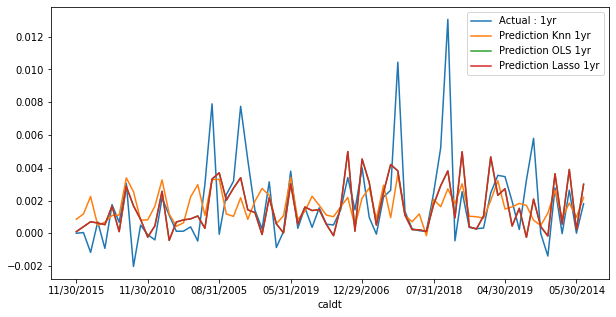

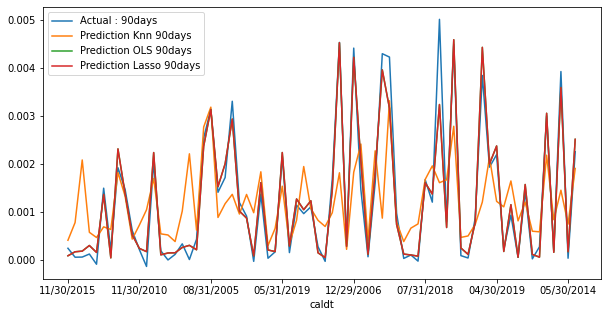

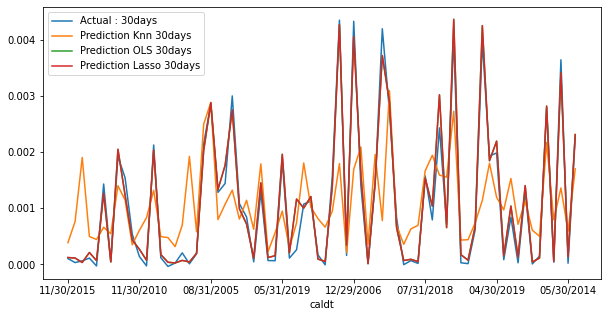

In [33]:
pd.DataFrame({'Actual : 1yr': Y_validation.loc[:, 'b1ret_pred'],
              'Prediction Knn 1yr': Y_predKnn.loc[:, 'b1ret_pred'],
              'Prediction OLS 1yr': Y_predOLS.loc[:, 'b1ret_pred'],
              'Prediction Lasso 1yr': Y_predLasso.loc[:, 'b1ret_pred']}).plot(figsize=(10,5))
#residual_knn_1=(Y_validation.loc[:, 'b1ret_pred']- Y_predKnn.loc[:, 'b1ret_pred'])
#residual_OLS_1=(Y_validation.loc[:, 'b1ret_pred']- Y_predOLS.loc[:, 'b1ret_pred'])

pd.DataFrame({'Actual : 90days': Y_validation.loc[:, 't90ret_pred'],
              'Prediction Knn 90days': Y_predKnn.loc[:, 't90ret_pred'],
              'Prediction OLS 90days': Y_predOLS.loc[:, 't90ret_pred'],
              'Prediction Lasso 90days': Y_predLasso.loc[:, 't90ret_pred']}).plot(figsize=(10,5))
#residual_knn_2=(Y_validation.loc[:, 't90ret_pred']- Y_predKnn.loc[:, 't90ret_pred'])
#residual_OLS_2=(Y_validation.loc[:, 't90ret_pred']- Y_predOLS.loc[:, 't90ret_pred'])

pd.DataFrame({'Actual : 30days': Y_validation.loc[:, 't30ret_pred'],
              'Prediction Knn 30days': Y_predKnn.loc[:, 't30ret_pred'],
              'Prediction OLS 30days': Y_predOLS.loc[:, 't30ret_pred'],
              'Prediction Lasso 30days': Y_predLasso.loc[:, 't30ret_pred']}).plot(figsize=(10,5))
#residual_knn_3=(Y_validation.loc[:, 't30ret_pred']- Y_predKnn.loc[:, 't30ret_pred'])
#residual_OLS_3=(Y_validation.loc[:, 't30ret_pred']- Y_predOLS.loc[:, 't30ret_pred'])

Overall, the Lasso and Linear Regression are comparable, however, the fitting with KNN is slighly poor as compared to the Lasso and Linear Regression. Also,the multitask learning with neural network is more intuitive for modeling many time series simultaneously.

##7.2 Residual Autocorrelation



In [34]:
#residuals
residual_knn_1=(Y_validation.loc[:, 'b1ret_pred']- Y_predKnn.loc[:, 'b1ret_pred'])
residual_OLS_1=(Y_validation.loc[:, 'b1ret_pred']- Y_predOLS.loc[:, 'b1ret_pred'])
residual_LASSO_1=((Y_validation.loc[:, 'b1ret_pred']- Y_predLasso.loc[:, 'b1ret_pred']))
residual_knn_2=(Y_validation.loc[:, 't90ret_pred']- Y_predKnn.loc[:, 't90ret_pred'])
residual_OLS_2=(Y_validation.loc[:, 't90ret_pred']- Y_predOLS.loc[:, 't90ret_pred'])
residual_LASSO_2=((Y_validation.loc[:, 't90ret_pred']- Y_predLasso.loc[:, 't90ret_pred']))
residual_knn_3=(Y_validation.loc[:, 't30ret_pred']- Y_predKnn.loc[:, 't30ret_pred'])
residual_OLS_3=(Y_validation.loc[:, 't30ret_pred']- Y_predOLS.loc[:, 't30ret_pred'])
residual_LASSO_3=((Y_validation.loc[:, 't30ret_pred']- Y_predLasso.loc[:, 't30ret_pred']))

In [35]:
# if the p-value of the test is greater than the reqired significance level(>0.05), residuals are independent
import statsmodels.api as sm
residuals_set=[residual_knn_1,residual_knn_2,residual_knn_3,residual_LASSO_1,residual_LASSO_2,residual_LASSO_3,residual_OLS_1,residual_OLS_2,residual_OLS_3]
for residuals in residuals_set:
  lb= sm.stats.acorr_ljungbox(residuals, lags=[10],boxpierce= False)
  print(lb[1])


[0.5918634]
[0.11135418]
[0.141355]
[0.85633758]
[0.42191986]
[0.3378907]
[0.85634063]
[0.42188674]
[0.33787369]


The p_value are all greater than 0.05 which implies that the residuals are independent.

#8.Model Testing

##8.1 White Reality Check

average return -0.361376
[-4.59848047  3.89959263]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.5866


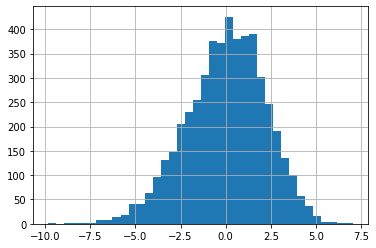

average return -0.361376
[-4.5720062   4.05207179]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.5986


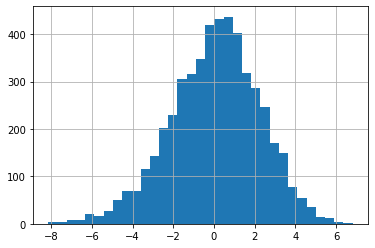

average return -0.361376
[-4.75168639  3.87986586]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.5802


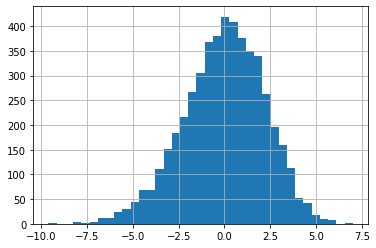

average return 0.447845
[-12.44497477  16.98718449]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.44199999999999995


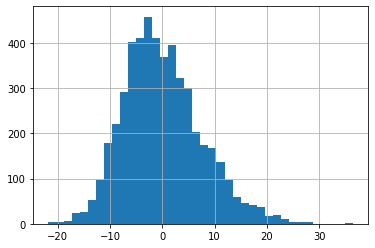

average return 7.150327
[-11.15038124  15.96483509]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.16400000000000003


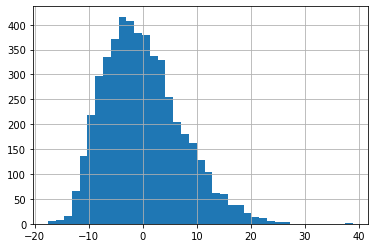

average return 0.447845
[-12.7711      15.60745714]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.4182


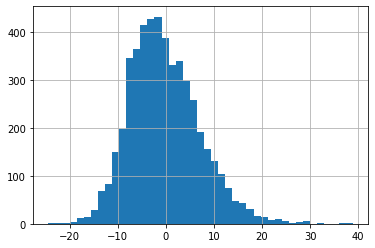

average return 5.469583
[-9.0993164   8.58181315]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.11180000000000001


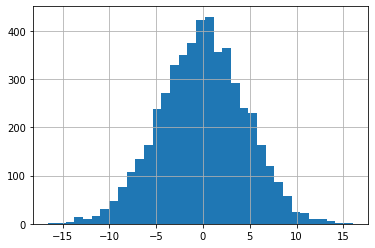

average return 5.469583
[-9.28798284  8.97441194]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.11180000000000001


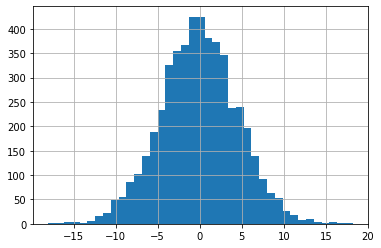

average return 5.469583
[-9.47121853  8.95002774]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.11040000000000005


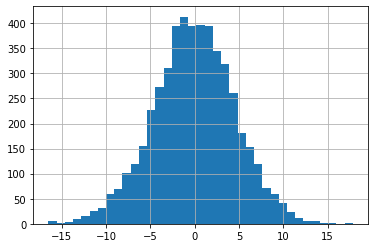

In [36]:
import WhiteRealityCheckFor1
model_set=[Y_predOLS,Y_predKnn, Y_predLasso]
treasury_set=['b1ret_pred','t90ret_pred', 't30ret_pred']
#for y_pred in model_set:
  #for treasuary_pred in treasury_set:
positions= np.where(Y_predOLS.loc[:, 't90ret_pred']>0,1,-1)
ret= (Y_validation.loc[:, 't90ret_pred'].pct_change(periods=1).fillna(0))
dsr= (ret.reset_index(drop=True))* pd.Series(positions).reset_index(drop=True).shift(0).fillna(0)
WhiteRealityCheckFor1.bootstrap(dsr)
plt.show()

positions= np.where(Y_predKnn.loc[:, 't90ret_pred']>0,1,-1)
ret= (Y_validation.loc[:, 't90ret_pred'].pct_change(periods=1).fillna(0))
dsr= (ret.reset_index(drop=True))* pd.Series(positions).reset_index(drop=True).shift(0).fillna(0)
WhiteRealityCheckFor1.bootstrap(dsr)
plt.show()

positions= np.where(Y_predLasso.loc[:, 't90ret_pred']>0,1,-1)
ret= (Y_validation.loc[:, 't90ret_pred'].pct_change(periods=1).fillna(0))
dsr= (ret.reset_index(drop=True))* pd.Series(positions).reset_index(drop=True).shift(0).fillna(0)
WhiteRealityCheckFor1.bootstrap(dsr)
plt.show()

positions= np.where(Y_predOLS.loc[:, 'b1ret_pred']>0,1,-1)
ret= (Y_validation.loc[:, 'b1ret_pred'].pct_change(periods=1).fillna(0))
dsr= (ret.reset_index(drop=True))* pd.Series(positions).reset_index(drop=True).shift(0).fillna(0)
WhiteRealityCheckFor1.bootstrap(dsr)
plt.show()

positions= np.where(Y_predKnn.loc[:, 'b1ret_pred']>0,1,-1)
ret= (Y_validation.loc[:, 'b1ret_pred'].pct_change(periods=1).fillna(0))
dsr= (ret.reset_index(drop=True))* pd.Series(positions).reset_index(drop=True).shift(0).fillna(0)
WhiteRealityCheckFor1.bootstrap(dsr)
plt.show()

positions= np.where(Y_predLasso.loc[:, 'b1ret_pred']>0,1,-1)
ret= (Y_validation.loc[:, 'b1ret_pred'].pct_change(periods=1).fillna(0))
dsr= (ret.reset_index(drop=True))* pd.Series(positions).reset_index(drop=True).shift(0).fillna(0)
WhiteRealityCheckFor1.bootstrap(dsr)
plt.show()

positions= np.where(Y_predOLS.loc[:, 't30ret_pred']>0,1,-1)
ret= (Y_validation.loc[:, 't30ret_pred'].pct_change(periods=1).fillna(0))
dsr= (ret.reset_index(drop=True))* pd.Series(positions).reset_index(drop=True).shift(0).fillna(0)
WhiteRealityCheckFor1.bootstrap(dsr)
plt.show()

positions= np.where(Y_predKnn.loc[:, 't30ret_pred']>0,1,-1)
ret= (Y_validation.loc[:, 't30ret_pred'].pct_change(periods=1).fillna(0))
dsr= (ret.reset_index(drop=True))* pd.Series(positions).reset_index(drop=True).shift(0).fillna(0)
WhiteRealityCheckFor1.bootstrap(dsr)
plt.show()

positions= np.where(Y_predLasso.loc[:, 't30ret_pred']>0,1,-1)
ret= (Y_validation.loc[:, 't30ret_pred'].pct_change(periods=1).fillna(0))
dsr= (ret.reset_index(drop=True))* pd.Series(positions).reset_index(drop=True).shift(0).fillna(0)
WhiteRealityCheckFor1.bootstrap(dsr)
plt.show()